In [10]:
# import necessary dependencies
import argparse
import os, sys
import time
from datetime import datetime
import time
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset

import torchvision
import numpy as np
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

## Prepare

In [11]:
# arguments
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

# parameters
RANDOM_SEED = 42
IMG_SIZE = 28
N_CLASSES = 10

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Device: cuda


In [12]:
# construct dataset
# total train set
train_set = torchvision.datasets.MNIST('./data/', train=True, download=True,
                 transform=torchvision.transforms.Compose([
                      torchvision.transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

# random omit one digit train set
omit_digit = random.randint(0,9)
print(f"randomly omitted digit {omit_digit}")
left_idx = train_set.targets != omit_digit
left_train_labels = train_set.targets[left_idx]
left_train_data = train_set.data[left_idx]
left_train_data = left_train_data.view(left_train_data.shape[0], -1, 28, 28).float()
print(f"total training size: {train_set.data.shape[0]}\ntraining size after omitted {omit_digit}: {left_train_data.shape[0]}")
left_train_loader = torch.utils.data.DataLoader(TensorDataset(left_train_data, left_train_labels),
                                          batch_size=TRAIN_BATCH_SIZE, shuffle=True)

# total test set
test_set = torchvision.datasets.MNIST('./data/', train=False, download=True,
                 transform=torchvision.transforms.Compose([
                      torchvision.transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=VAL_BATCH_SIZE, shuffle=True)

# omit digit test set
omit_idx = test_set.targets == omit_digit
omit_test_labels = test_set.targets[omit_idx]
omit_test_data = test_set.data[omit_idx]
omit_test_data = omit_test_data.view(omit_test_data.shape[0], -1, 28, 28).float()
print(f"\ntotal testing size: {test_set.data.shape[0]}\ntesting size of omitted digit {omit_digit}: {omit_test_data.shape[0]}")
omit_test_loader = torch.utils.data.DataLoader(TensorDataset(omit_test_data, omit_test_labels), 
                                               batch_size=VAL_BATCH_SIZE, shuffle=True)

randomly omitted digit 1
total training size: 60000
training size after omitted 1: 53258

total testing size: 10000
testing size of omitted digit 1: 1135


### Check Images

check left training images after omitting digit 1


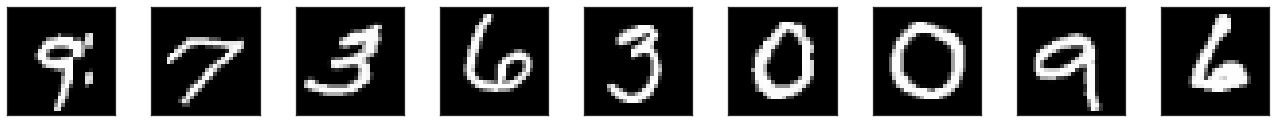

In [13]:
print(f"check left training images after omitting digit {omit_digit}")
_, (example_data, example_targets) = next(enumerate(left_train_loader))

fig = plt.figure(figsize=(18, 4))
for i in range(9):
    plt.subplot(1,9,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

check validation images with all digits


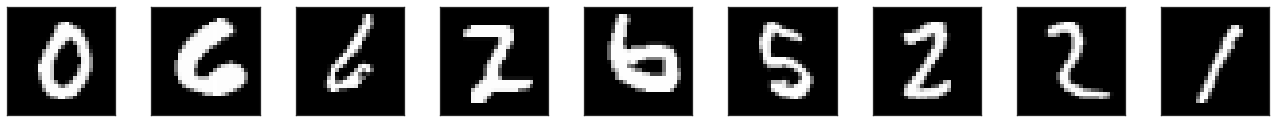

In [14]:
print(f"check validation images with all digits")
_, (example_data, example_targets) = next(enumerate(test_loader))

fig = plt.figure(figsize=(18, 4))
for i in range(9):
    plt.subplot(1,9,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

## Training

In [15]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''  
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    acc = correct_pred.float() / n
    return acc.item()

def plot_losses(train_losses, valid_losses, title_prefix):
    '''
    Function for plotting training and validation losses
    '''
    plt.figure(figsize=(6, 4),dpi=100)
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    
    plt.plot(train_losses, color='blue', label='Training loss') 
    plt.plot(valid_losses, color='red', label='Validation loss')
    plt.title(f"{title_prefix}: Loss over epochs") 
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

def train(train_loader, model, criterion, optimizer, device, teacher_model=None):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        if not teacher_model:
            loss = criterion(y_hat, y_true)
        else:
            with torch.no_grad():
                y_teacher = teacher_model(X)
            loss = criterion(y_hat, y_true, y_teacher)
            
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, train_criterion, valid_criterion, optimizer, train_loader, valid_loader, 
                  epochs, device, params, print_every=1, teacher_model=None):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    acc_epochs = []
    train_accus = []
    valid_accus = []
    

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, train_criterion, optimizer, device, teacher_model)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, valid_criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            acc_epochs.append(epoch)
            train_acc = get_accuracy(model, train_loader, device=device)
            train_accus.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            valid_accus.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    # save metrics
    plot_losses(train_losses, valid_losses, params['title'])
    res_acc = pd.DataFrame({
        "acc_epoch": acc_epochs,
        "train_accus": train_accus,
        "valid_accus": valid_accus
    })
    res_loss = pd.DataFrame({
        "loss_epoch": range(0, epochs),
        "train_losses": train_losses,
        "valid_losses": valid_losses,
    })
    str_time = datetime.now().strftime("%m-%d_%H-%M")
    res_acc.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_accus.csv", index=False)
    res_loss.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_losses.csv", index=False)
    
    return model, optimizer, (train_losses, valid_losses)

### Models

In [16]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Conv2d(1, 6, 5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        logits = self.model(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

class StudentNet(nn.Module):

    def __init__(self, n_classes):
        super(StudentNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Conv2d(1, 1, 5, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(1, 2, 5, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(32, 10),
        )
 
    def forward(self, x):
        logits = self.model(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

### Train Teacher Model

In [17]:
LeNet5_CHECKPOINT = "LeNet5_trained_parameters.pt"
torch.manual_seed(RANDOM_SEED)

model_teacher = LeNet5(N_CLASSES).to(DEVICE)

if os.path.exists(LeNet5_CHECKPOINT):
    # load model Directly
    print("==========> Load Parameters")
    model_teacher.load_state_dict(torch.load(LeNet5_CHECKPOINT))

else:
    # If model not trained 
    print("==========> Not find checkpoint, train")

    LEARNING_RATE = 0.001
    N_EPOCHS = 25
    optimizer = torch.optim.Adam(model_teacher.parameters(), lr=LEARNING_RATE)
    train_criterion = nn.CrossEntropyLoss()
    valid_criterion = nn.CrossEntropyLoss()
    params = {"dir":'.',
              "prefix": "teacher",
              "title": "teacher"
             }
    
    model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                                train_loader, test_loader, N_EPOCHS, DEVICE, params)

    # Save model 
    torch.save(model_teacher.state_dict(), LeNet5_CHECKPOINT)

==========> Load Parameters


### Q4 Train Student Model

#### all digits: student model with ground truth labels

=======> Student trained on Ground Truth
08:14:43 --- Epoch: 0	Train loss: 0.5321	Valid loss: 13.9114	Train accuracy: 90.36	Valid accuracy: 97.97
08:15:03 --- Epoch: 1	Train loss: 0.3097	Valid loss: 48.4026	Train accuracy: 90.73	Valid accuracy: 91.54
08:15:23 --- Epoch: 2	Train loss: 0.2859	Valid loss: 29.3717	Train accuracy: 92.18	Valid accuracy: 95.51
08:15:43 --- Epoch: 3	Train loss: 0.2742	Valid loss: 17.1564	Train accuracy: 92.11	Valid accuracy: 97.44
08:16:04 --- Epoch: 4	Train loss: 0.2641	Valid loss: 12.6301	Train accuracy: 92.04	Valid accuracy: 97.89
08:16:24 --- Epoch: 5	Train loss: 0.2551	Valid loss: 13.5348	Train accuracy: 92.53	Valid accuracy: 97.80
08:16:44 --- Epoch: 6	Train loss: 0.2410	Valid loss: 24.2234	Train accuracy: 93.36	Valid accuracy: 96.74
08:17:04 --- Epoch: 7	Train loss: 0.2336	Valid loss: 7.4879	Train accuracy: 93.53	Valid accuracy: 98.85
08:17:24 --- Epoch: 8	Train loss: 0.2290	Valid loss: 8.8320	Train accuracy: 93.52	Valid accuracy: 98.68
08:17:44 --- Epo

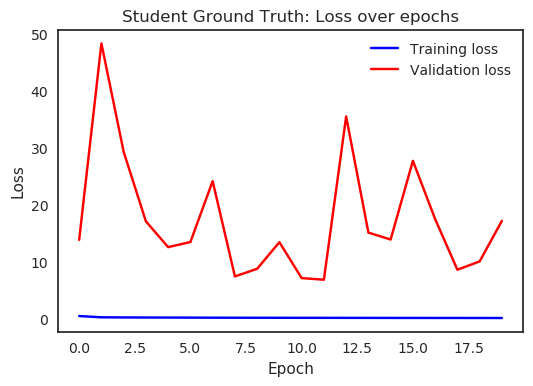

In [18]:
LEARNING_RATE = 0.01
N_EPOCHS = 20

print(f"=======> Student trained on Ground Truth")
model_s = StudentNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_s.parameters(), lr=LEARNING_RATE)

train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()


dir_path = "./student_models/student_ground_truth"
params = {"dir": dir_path,
          "prefix": "student", 
          "title": "Student Ground Truth"
         }

if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

model_s, optimizer, _ = training_loop(model_s, train_criterion, valid_criterion, optimizer, train_loader, omit_test_loader,
                                    N_EPOCHS, DEVICE, params)
torch.save(model_s.state_dict(), f"{dir_path}/student_ground_truth_parameters.pt")

#### omitted digits: student model with ground truth labels

=======> Student trained on Ground Truth
08:21:14 --- Epoch: 0	Train loss: 0.9499	Valid loss: 53.1817	Train accuracy: 87.03	Valid accuracy: 0.00
08:21:24 --- Epoch: 1	Train loss: 0.3337	Valid loss: 50.2018	Train accuracy: 90.09	Valid accuracy: 0.00
08:21:34 --- Epoch: 2	Train loss: 0.2984	Valid loss: 55.3573	Train accuracy: 91.49	Valid accuracy: 0.00
08:21:46 --- Epoch: 3	Train loss: 0.2777	Valid loss: 59.2233	Train accuracy: 91.15	Valid accuracy: 0.00
08:21:55 --- Epoch: 4	Train loss: 0.2643	Valid loss: 42.8337	Train accuracy: 92.26	Valid accuracy: 0.00
08:22:05 --- Epoch: 5	Train loss: 0.2501	Valid loss: 51.6428	Train accuracy: 92.72	Valid accuracy: 0.00
08:22:15 --- Epoch: 6	Train loss: 0.2454	Valid loss: 47.9186	Train accuracy: 92.86	Valid accuracy: 0.00
08:22:24 --- Epoch: 7	Train loss: 0.2373	Valid loss: 49.6269	Train accuracy: 92.72	Valid accuracy: 0.00
08:22:34 --- Epoch: 8	Train loss: 0.2409	Valid loss: 43.7479	Train accuracy: 92.21	Valid accuracy: 0.00
08:22:44 --- Epoch: 9	T

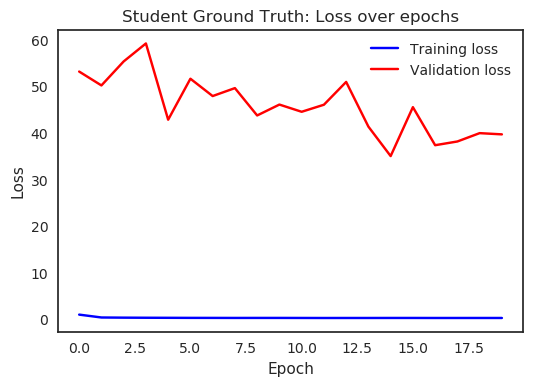

In [19]:
LEARNING_RATE = 0.01
N_EPOCHS = 20

print(f"=======> Student trained on Ground Truth")
model_s = StudentNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_s.parameters(), lr=LEARNING_RATE)

train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()


dir_path = "./student_models/student_ground_truth"
params = {"dir": dir_path,
          "prefix": "student", 
          "title": "Student Ground Truth"
         }

if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

model_s, optimizer, _ = training_loop(model_s, train_criterion, valid_criterion, optimizer, left_train_loader, omit_test_loader,
                                    N_EPOCHS, DEVICE, params)
torch.save(model_s.state_dict(), f"{dir_path}/student_ground_truth_parameters.pt")

#### all digits: student model with soft labels

In [20]:
class SoftCrossEntropyLoss(nn.Module):
    def __init__(self, temperature, alpha):
        super(SoftCrossEntropyLoss, self).__init__()
        self.T = temperature
        self.alpha = alpha
    
    def forward(self, student_pred, label, teacher_pred):
        return nn.KLDivLoss(reduction="batchmean")(F.log_softmax(student_pred/self.T,dim=1), F.softmax(teacher_pred[0]/self.T, dim=1)) * self.alpha * self.T * self.T + \
    F.cross_entropy(student_pred, label) * (1-self.alpha)


# Train
T = 3
LEARNING_RATE = 0.01
N_EPOCHS = 20
ALPHA = 0.9

=======> Temperature: 3
08:24:54 --- Epoch: 0	Train loss: 5.3077	Valid loss: 118.3541	Train accuracy: 89.57	Valid accuracy: 1.15
08:25:17 --- Epoch: 1	Train loss: 1.9614	Valid loss: 144.4757	Train accuracy: 92.83	Valid accuracy: 0.70
08:25:41 --- Epoch: 2	Train loss: 1.6124	Valid loss: 142.9731	Train accuracy: 93.66	Valid accuracy: 0.18
08:26:04 --- Epoch: 3	Train loss: 1.5051	Valid loss: 122.9001	Train accuracy: 93.77	Valid accuracy: 0.18
08:26:29 --- Epoch: 4	Train loss: 1.4587	Valid loss: 134.3653	Train accuracy: 93.66	Valid accuracy: 0.35
08:26:54 --- Epoch: 5	Train loss: 1.4062	Valid loss: 146.4851	Train accuracy: 94.54	Valid accuracy: 0.18
08:27:19 --- Epoch: 6	Train loss: 1.3815	Valid loss: 190.2227	Train accuracy: 94.38	Valid accuracy: 0.18
08:27:44 --- Epoch: 7	Train loss: 1.3445	Valid loss: 154.4419	Train accuracy: 94.44	Valid accuracy: 0.00
08:28:09 --- Epoch: 8	Train loss: 1.3140	Valid loss: 171.2210	Train accuracy: 94.74	Valid accuracy: 0.00
08:28:32 --- Epoch: 9	Train los

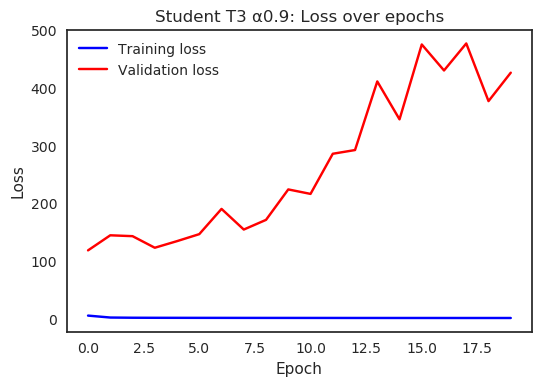

In [21]:
print(f"=======> Temperature: {T}")
model_s = StudentNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_s.parameters(), lr=LEARNING_RATE)

valid_criterion = nn.CrossEntropyLoss()
train_criterion = SoftCrossEntropyLoss(T, ALPHA)

prefix = f"student_T{T}_α{ALPHA}"
dir_path = f"./student_models/{prefix}"
if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

params = {"dir": dir_path,
      "prefix": prefix, 
      "title": f"Student T{T} α{ALPHA}"
     }

model_s, optimizer, _ = training_loop(model_s, train_criterion, valid_criterion, optimizer, train_loader, omit_test_loader,
                                    N_EPOCHS, DEVICE, params, teacher_model=model_teacher)
torch.save(model_s.state_dict(), f"{dir_path}/{prefix}_parameters.pt")  

#### omitted digits: student model with soft labels

=======> Soft label with omitted digits
08:32:52 --- Epoch: 0	Train loss: 5.4631	Valid loss: 18.4000	Train accuracy: 88.71	Valid accuracy: 0.00
08:33:05 --- Epoch: 1	Train loss: 2.8490	Valid loss: 13.1778	Train accuracy: 89.00	Valid accuracy: 19.12
08:33:20 --- Epoch: 2	Train loss: 2.7268	Valid loss: 15.3002	Train accuracy: 89.84	Valid accuracy: 1.50
08:33:34 --- Epoch: 3	Train loss: 2.6681	Valid loss: 10.9340	Train accuracy: 90.35	Valid accuracy: 9.25
08:33:46 --- Epoch: 4	Train loss: 2.6068	Valid loss: 16.4688	Train accuracy: 88.82	Valid accuracy: 3.96
08:33:56 --- Epoch: 5	Train loss: 2.5246	Valid loss: 11.9084	Train accuracy: 91.23	Valid accuracy: 20.53
08:34:10 --- Epoch: 6	Train loss: 2.3671	Valid loss: 11.7814	Train accuracy: 91.55	Valid accuracy: 4.67
08:34:23 --- Epoch: 7	Train loss: 2.3351	Valid loss: 11.0182	Train accuracy: 92.02	Valid accuracy: 23.61
08:34:39 --- Epoch: 8	Train loss: 2.2967	Valid loss: 15.5881	Train accuracy: 91.04	Valid accuracy: 12.42
08:34:55 --- Epoch: 

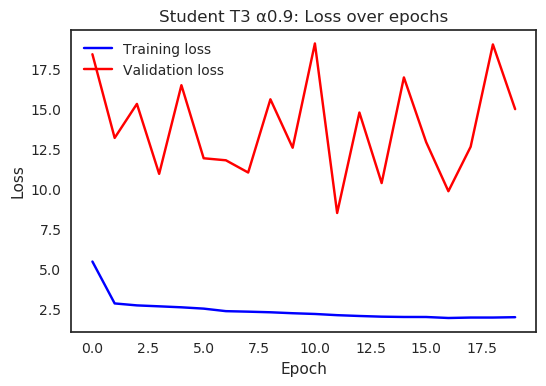

In [22]:
print(f"=======> Soft label with omitted digits")
model_s = StudentNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_s.parameters(), lr=LEARNING_RATE)

valid_criterion = nn.CrossEntropyLoss()
train_criterion = SoftCrossEntropyLoss(T, ALPHA)
prefix = f"student_T{T}_α{ALPHA}"
dir_path = f"./student_models/{prefix}"
if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

params = {"dir": dir_path,
      "prefix": prefix, 
      "title": f"Student T{T} α{ALPHA}"
     }

model_s, optimizer, _ = training_loop(model_s, train_criterion, valid_criterion, optimizer, left_train_loader, omit_test_loader,
                                    N_EPOCHS, DEVICE, params, teacher_model=model_teacher)
torch.save(model_s.state_dict(), f"{dir_path}/{prefix}_parameters.pt")  